# Titanic Challenge

In [1]:
# import sys
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install sklearn

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/input/titanic/test.csv
kaggle/input/titanic/titanic.zip
kaggle/input/titanic/train.csv
kaggle/input/titanic/gender_submission.csv


### Look for columns with missing values

In [3]:
t_train_orig = pd.read_csv("kaggle/input/titanic/train.csv")
t_train_orig.name = "Titanic Training Set"
t_test_orig = pd.read_csv("kaggle/input/titanic/test.csv")
t_test_orig.name = "Titanic Test Set"

def display_missing(df):    
    for col in df.columns.tolist(): 
        if df[col].isnull().sum() > 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

dfs = [t_train_orig, t_test_orig]

for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Titanic Training Set
Age column missing values: 177
Cabin column missing values: 687
Embarked column missing values: 2


Titanic Test Set
Age column missing values: 86
Fare column missing values: 1
Cabin column missing values: 327




###  Women were much more likely to survive than men

In [4]:
t_train_orig['Died']= t_train_orig['Survived'].map(lambda survived: 0 if survived == 1 else 1)
t_train_orig.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true')

### There's a correlation between ticket price and the likelihood of survival

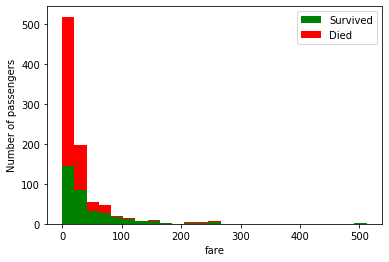

In [5]:
import matplotlib.pyplot as plt
t = t_train_orig
fare_survived =t[t['Survived'] == 1]['Fare'] 
fare_died = t[t['Survived'] == 0]['Fare'] 
plt.hist([fare_survived, fare_died], stacked=True, color = ['g', 'r'], 
         bins = 25, label=['Survived', 'Died'])
plt.xlabel('fare')
plt.ylabel('Number of passengers')
plt.legend()

### Survival  is correlated best with class and fare
so we can fill in nulls with more representative values

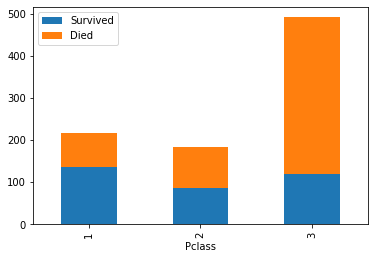

In [6]:
t_train_corr = t_train_orig.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
t_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)

groups = t_train_corr[(0.1 < t_train_corr["Correlation Coefficient"]) & (t_train_corr["Correlation Coefficient"] < .85)].groupby('Feature 1')
groups.get_group('Survived')

t_train_orig.groupby('Pclass').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true')

### See what  Age is correlated with best
so we can fill in nulls with more representative values

In [7]:
groups.get_group('Age')

,Feature 1,Feature 2,Correlation Coefficient
15,Age,Pclass,0.369226
20,Age,SibSp,0.308247
28,Age,Parch,0.189119


### Sample training data

In [8]:
t_train_orig.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,0
422,423,0,3,"Zimmerman, Mr. Leo",male,29.0,0,0,315082,7.8750,NaN,S,1
336,337,0,1,"Pears, Mr. Thomas Clinton",male,29.0,1,0,113776,66.6000,C2,S,1
649,650,1,3,"Stanley, Miss. Amy Zillah Elsie",female,23.0,0,0,CA. 2314,7.5500,NaN,S,0
381,382,1,3,"Nakid, Miss. Maria (""Mary"")",female,1.0,0,2,2653,15.7417,NaN,C,0
212,213,0,3,"Perkin, Mr. John Henry",male,22.0,0,0,A/5 21174,7.2500,NaN,S,1
411,412,0,3,"Hart, Mr. Henry",male,NaN,0,0,394140,6.8583,NaN,Q,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,0
334,335,1,1,"Frauenthal, Mrs. Henry William (Clara Heinshei...",female,NaN,1,0,PC 17611,133.6500,NaN,S,0
845,846,0,3,"Abbing, Mr. Anthony",male,42.0,0,0,C.A. 5547,7.5500,NaN,S,1


## Feature exploration

Here are some initial ideas:
* Pclass (1 > 2 > 3)
* Fare ($$ > $)
* Sex (female > male)
* CabinPresent (1 > 0)
* Is child over 12 (1 > 0)


In [9]:
import math

t_train = t_train_orig

# sex to numeric
t_train['SexNumeric'] = np.where(t_train['Sex'] == "male", 0, 1)

# fill in missing fare with median fare for passengers in the same class
median_fares = t_train.groupby('Pclass')['Fare'].median()
def fare_for_class(row):
    return median_fares[row['Pclass']] if row['Fare'] == 0 else row['Fare']
t_train['FareAdjusted'] = t_train.apply(fare_for_class,axis=1)

# TODO: update AgeAdjusted to take into account title to refine the likely age, so that a child with
# missing age doesn't get classified as an adult.. a male child should be much more likely to survive
# so that should help

# extract titles
#get_index = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y][0]

t_train['Title'] = t_train_orig['Name'].map(lambda name: [title for title in name.split(' ') if '.' in title][0])
#all_titles = t_train['Title'].unique()
titles_esteemed_first = {
    'Countess.': 17,
    'Lady.': 16,
    'Rev.': 15,
    'Jonkheer.': 14,
    'Master.': 13,
    'Major.' : 12,
    'Don.': 11,
    'Dr.' : 10,
    'Col.': 9,
    'Capt.': 8,
    'Mlle.': 7,
    'Miss.': 6,
    'Ms.': 5,
    'Mrs.': 4,
    'Mme.': 3,
    'Sir.': 2,
    'Mr.': 1
}

t_train['TitleNumeric'] = t_train['Title'].map(lambda title: titles_esteemed_first[title])


feature_cols = ['FareAdjusted', 'Pclass', 'SexNumeric', 'TitleNumeric']
t_train[np.isnan(t_train['Age']) & (t_train['Title'] == 'Miss.')][feature_cols].sample(12)

t_train[feature_cols].sample(12)

,FareAdjusted,Pclass,SexNumeric,TitleNumeric
673,13.0000,2,0,1
247,14.5000,2,1,4
739,7.8958,3,0,1
104,7.9250,3,0,1
8,11.1333,3,1,4
762,7.2292,3,0,1
437,18.7500,2,1,4
110,52.0000,1,0,1
350,9.2250,3,0,1
320,7.2500,3,0,1


In [10]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

X = t_train[feature_cols]
y = t_train.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8208955223880597


## Try a random forrest classifier

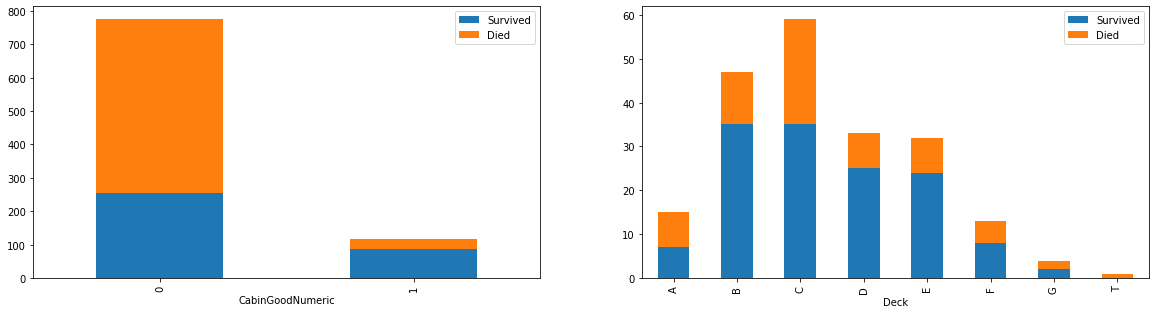

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, False, figsize=(20,5))

# simply having s cabin assigned increases chances of survival
t_train['CabinGoodNumeric'] =  t_train['Deck'].map(lambda letter: 1 if (letter in "BDEG") else 0)
t_train_orig.groupby('CabinGoodNumeric').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true', ax=ax1)


# correlate deck with survival rate for assigned cabins
import string
t_train['Deck'] = \
    t_train['Cabin'].map(lambda cabin: cabin[0] if (type(cabin) == str) else "U")
t_train_orig[t_train_orig['Deck'] != 'U'].groupby('Deck').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true', ax=ax2)


# CabinGoodNumeric doesn't yet seem to inprove things.. can it be made to be useful?
# why is it not a very important feature according to random forrest.. is it because most people don't have a cabin?

In [25]:
from sklearn.ensemble import RandomForestClassifier

feature_cols = ['FareAdjusted', 'Pclass', 'SexNumeric', 'TitleNumeric', 'CabinGoodNumeric']

X = t_train[feature_cols]
y = t_train.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

rfc = RandomForestClassifier(n_estimators=100, max_depth=8,
                             min_samples_split = 3, min_samples_leaf=2, 
                             max_features=0.75, n_jobs=-1)
rfc.fit(X_train,y_train) 

print(f'feature importance: {rfc.feature_importances_}')
print(f'score train: {rfc.score(X_train, y_train)}')
print(f'score:       {rfc.score(X_test, y_test)}')


feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances

feature importance: [0.28416215 0.1167881  0.17089375 0.37882037 0.04933563]
score train: 0.8908507223113965
score:       0.8022388059701493


,importance
TitleNumeric,0.378820
FareAdjusted,0.284162
SexNumeric,0.170894
Pclass,0.116788
CabinGoodNumeric,0.049336


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_train)

prob = lr.predict_proba(X)

print(f'probabilty (count = {len(prob)}\n{prob}\n')
print(f'score: {clf.score(X_test, y_test)}')


### Odds and Ends -- things I may want to use

In [ ]:
# Things I did not use

# passenger has a cabin (if NaN, no cabin)
t_train['CabinPresent'] = t_train['Cabin'].fillna(0)
t_train['CabinPresent'] = np.where(t_train['CabinPresent'] != 0, 1, 0)

# location of cabin.. naive mapping based on the first letter of the Cabin location 
import string
t_train['Deck'] = \
    t_train['Cabin'].map(lambda cabin: cabin[0] if (type(cabin) == str) else "U")

# thought large number of siblings might help (it didn't)
t_train['SibSpLarge'] = t_train['SibSp'].map(lambda ct: 1 if ct > 3 else 0)
#t_train['SibSpLarge'].value_counts()

# people with the same last name may be a family; add feature that represent this count to each person
# doesn't seem to help
t_train['LastName'] = t_train['Name'].map(lambda name: name.split(',')[0])
familyCount = t_train.groupby('LastName')['LastName'].count()
t_train['FamilyCount'] = t_train['LastName'].map(lambda lastName: familyCount[lastName])
t_train['FamilyScore'] = t_train.SibSp + t_train.Parch

t_train['FamSize_Single'] = t_train['FamilyScore'].map(lambda score: score == 1)
t_train['FamSize_Small'] = t_train['FamilyScore'].map(lambda score: 1 < score <= 3)
t_train['FamSize_Medium'] = t_train['FamilyScore'].map(lambda score: 3 < score <= 5)
t_train['FamSize_Large'] = t_train['FamilyScore'].map(lambda score: 5 < score)
# next, try using the SibSp to correlate against this count..
# but do people with siblings or spouses have a higher chance of surviving? 

#t_train['Fare'].map(lambda amt: int(amt / 10) * 10).value_counts()
ave_fare = t_train['Fare'].median()
t_train['FareWithDefault'] = t_train['Fare'].map(lambda fare: fare if fare > 0 else ave_fare)


# this actually hurts
t_train['IsChild'] = t_train['AgeAdjusted'].map(lambda age: 1 if (age <= 12.0) else 0)


# extract titles
get_index = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y][0]

t_train['Title'] = t_train_orig['Name'].map(lambda name: [title for title in name.split(' ') if '.' in title][0])
titles = t_train['Title'].unique()

t_train['TitleNumeric'] = t_train['Title'].map(lambda title: get_index(title, titles))

feature_cols = ['FareAdjusted', 'Pclass', 'SexNumeric', 'TitleNumeric']

In [ ]:
t_train_corr = t_train.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
t_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)

groups = t_train_corr[(0.1 < t_train_corr["Correlation Coefficient"]) & (t_train_corr["Correlation Coefficient"] < .6)].groupby('Feature 1')
for feature in feature_cols:
    print(groups.get_group(feature))